#  实验结果记录
前面：因为对Normalize理解不深，发现，手算，nn.normalize, torchvision 之间有区别，减肥feature_norm.ipynb


In [12]:
# 记录使用input anderson normalize(0, 1)后的结果
import h5py
import numpy as np
import matplotlib.pyplot as plt

import os
import torch
import pandas as pd
import torchvision.transforms as transforms


In [8]:
def plot_loss(loss_f):
    train_l = loss_f['model_000']['train'][:]
    validate_l = loss_f['model_000']['validate'][:]
    test = loss_f['model_000']['test'][:]
    plt.plot(np.arange(len(train_l))+1, train_l, '-o', label='train')
    plt.plot(np.arange(len(validate_l))+1, validate_l, '-o', label='validate')
    plt.plot(len(train_l), test[0], '-o', label='test')
    plt.legend()
    plt.title('input normalize(0, 1) 4000 train 10 epoch')

[0.10132153 0.03943886 0.02010389 0.02571163 0.00729846 0.01066378
 0.00389246 0.01241311 0.01354597 0.00460611]


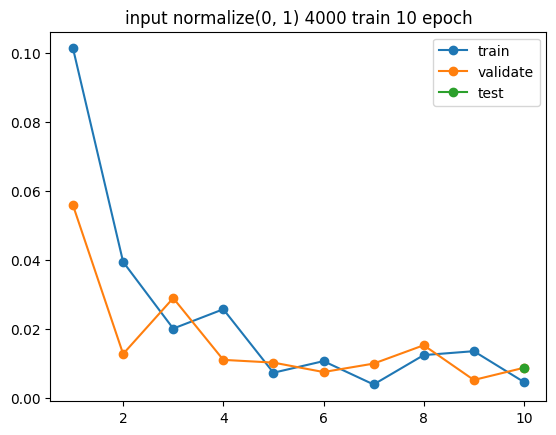

In [9]:
loss_f = h5py.File('input_norm.h5', 'r')
train_no_norm = loss_f['model_000']['train'][:]
print(train_no_norm)
plot_loss(loss_f)

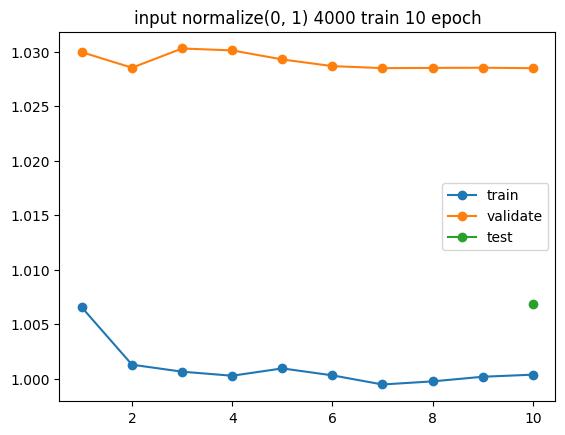

In [10]:
# 因为数值尺度不一样，所以loss大小值不一样，可以将现在loss，还原成原先的。
loss_f = h5py.File('a_c_norm.h5', 'r')
plot_loss(loss_f)

In [13]:
loss_f = h5py.File('a_c_norm.h5', 'r')
t_data = lambda x:  torch.tensor(np.array(x, dtype=np.float64), dtype=torch.float64)
train_l = t_data(loss_f['model_000']['train'][:])
validate_l = t_data(loss_f['model_000']['validate'][:])
test = t_data(loss_f['model_000']['test'][:])
#transform
mean_h5 = h5py.File('../datasets/4000_mean_std.h5', 'r')
mean, std = mean_h5['chebyshev_mean'][0], mean_h5['chebyshev_std'][0]
train_rescale = transforms.Compose([transforms.Normalize(mean = [0.], std = 1/std),
                                transforms.Normalize(mean = -mean, std=[1.]),])(train_l.view(1,-1,1,1))
validate_rescale = transforms.Compose([transforms.Normalize(mean=[0.], std = 1/std),
                                transforms.Normalize(mean = -mean, std=[1.]),])(validate_l.view(1,-1,1,1))
test_rescale = transforms.Compose([transforms.Normalize(mean =[0.], std = 1/std),
                                transforms.Normalize(mean = -mean, std=[1.]),])(test.view(1,-1,1,1))

In [15]:
# loss的比较，使用训练集的mean,std 将误差reverse transform, 这样的比较误差是小了，但是不知道，实际效果好不好呀。？
print(f'train_l {train_l}')
print(f'train_rescale {train_rescale.flatten()}')
print(f'train_no_norm {train_no_norm}')
mean, std, train_rescale.flatten().std()
#这里的loss都一样，是不是学习率太小，rescale后，基本不变，与图片相符。）

train_l tensor([1.0065, 1.0013, 1.0007, 1.0003, 1.0010, 1.0003, 0.9995, 0.9998, 1.0002,
        1.0004], dtype=torch.float64)
train_rescale tensor([0.0130, 0.0130, 0.0130, 0.0130, 0.0130, 0.0130, 0.0130, 0.0130, 0.0130,
        0.0130], dtype=torch.float64)
train_no_norm [0.10132153 0.03943886 0.02010389 0.02571163 0.00729846 0.01066378
 0.00389246 0.01241311 0.01354597 0.00460611]


(0.012880924261966794,
 8.715820229306036e-05,
 tensor(1.7620e-07, dtype=torch.float64))

In [ ]:
#， 根据图a_c_norm_2.h5中的loss, 将y_pred reverse transforms,在与原先的y_batch计算rmse，看loss是否减小。
# train有shuffle，所以无法对应原

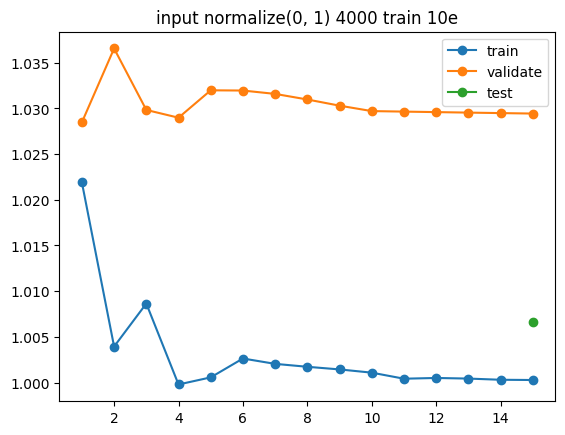

In [107]:
# 将LR从0.005，变为0.05, step_size从10->5, n_epoch=15
loss_f = h5py.File('a_c_norm_2.h5', 'r')
plot_loss(loss_f)

In [21]:
# 将规范化的数据保存成h5文件


csv_file =  os.path.join('../datasets', f"L{L}N{n}_4000.csv")
L=6
n=255
channel = n*2+2+L+2

data = torch.tensor(np.array(pd.read_csv(csv_file)), dtype=torch.float64)
data = data.view(-1, channel, 1, 1)
anderson = data[:, :L+2, :, :]
chebyshev = data[:, L+2: L + 2 + n + 1, :, :]
Greens = data[:, L + 2 + n + 1:, :, :]
        
mean = data.mean(dim=0).squeeze()
std = data.std(dim=0).squeeze()
mean = (mean[:L+2], mean[L+2: L + 2 + n + 1])
std = (std[:L+2], std[L+2: L + 2 + n + 1])
mean[0], std[0]

(tensor([ 4.9801e+00, -3.6410e-03, -2.2448e-02,  2.9873e-02,  4.0877e-02,
          7.4733e-01,  7.5317e-01,  7.6191e-01], dtype=torch.float64),
 tensor([2.9022, 1.4295, 2.8808, 2.8727, 2.8449, 0.4304, 0.4306, 0.4337],
        dtype=torch.float64))

In [22]:
# save mean and std into h5
h5f = h5py.File('4000_mean_std.h5', 'w')
h5f.create_dataset('anderson_mean', data=mean[0])
h5f.create_dataset('anderson_std', data=std[0])
h5f.create_dataset('chebyshev_mean', data=mean[1])
h5f.create_dataset('chebyshev_std', data=std[1])
h5f.close()

In [23]:

n_anderson = transforms.Normalize(mean=mean[0], std=std[0])(anderson)
n_chebyshev = transforms.Normalize(mean=mean[1], std=std[1])(chebyshev)

In [26]:
n_anderson.shape, n_anderson[0, :, 0, 0], anderson[0, :, 0, 0]

(torch.Size([4000, 8, 1, 1]),
 tensor([ 0.6838,  0.1470,  0.5741,  1.5223, -1.4679,  0.2659,  1.3651, -0.7920],
        dtype=torch.float64),
 tensor([ 6.9647,  0.2065,  1.6314,  4.4030, -4.1352,  0.8618,  1.3410,  0.4184],
        dtype=torch.float64))

In [28]:
n_chebyshev.shape, n_chebyshev[0, :8, 0, 0], chebyshev[0, :8, 0, 0]

(torch.Size([4000, 256, 1, 1]),
 tensor([ 0.4127,  0.1582,  0.4275, -0.1513, -0.4722,  0.1331,  0.5468, -0.0954],
        dtype=torch.float64),
 tensor([ 0.0129,  0.0002, -0.0233, -0.0005,  0.0185,  0.0006, -0.0127, -0.0005],
        dtype=torch.float64))

In [33]:
h5norm_dataset = h5py.File('L6N255_norm_4000.h5', 'w')
h5norm_dataset.create_dataset('chebyshev', data=n_chebyshev)
h5norm_dataset.create_dataset('anderson', data=n_anderson)
h5norm_dataset.close()

In [35]:
# 将原始数据集从(n, w) 改成（n, channel=w, 1, 1) , torchvision 格式
h5_dataset = h5py.File('L6N255_4000.h5', 'w')
h5_dataset.create_dataset('chebyshev', data=chebyshev)
h5_dataset.create_dataset('anderson', data=anderson)
h5_dataset.create_dataset('Greens', data=Greens)
h5_dataset.close()


In [38]:
# todo save h5 数据类型为f8， 精度变了？
def save2h5(csv_file, save_f):
    h5 = h5py.File(save_f, 'w')
    L=6
    n=255
    channel = n*2+2+L+2
    
    data = torch.tensor(np.array(pd.read_csv(csv_file)), dtype=torch.float64)
    data = data.view(-1, channel, 1, 1)
    anderson = data[:, :L+2, :, :]
    chebyshev = data[:, L+2: L + 2 + n + 1, :, :]
    Greens = data[:, L + 2 + n + 1:, :, :]
    # 保证文件不存在
    h5.create_dataset('chebyshev', data=chebyshev, dtype='float64')
    h5.create_dataset('anderson', data=anderson, dtype='float64')
    h5.create_dataset('Greens', data=Greens, dtype='float64')
    h5.close()
    

In [43]:
csv_file = '../datasets/L6N255_testing_400.csv'
save_f = 'L6N255_testing_400.h5'
save2h5(csv_file, save_f)

In [48]:
csv_file = '../datasets/L6N255_training_8.csv'
save_f = 'L6N255_8.h5'
save2h5(csv_file, save_f)

In [77]:
def save_norm_h5(origin_f, norm_f, mean_f):
    h5_o = h5py.File(origin_f, 'r')
    h5_mean = h5py.File(mean_f, 'r')
    h5_n = h5py.File(norm_f, 'w')

    anderson = torch.tensor(h5_o['anderson'][:], dtype=torch.float64)
    chebyshev = torch.tensor(h5_o['chebyshev'][:], dtype=torch.float64)
    Greens = h5_o['Greens'][:]
    a_mean = h5_mean['anderson_mean']
    c_mean = h5_mean['chebyshev_mean']
    a_std = h5_mean['anderson_std']
    c_std = h5_mean['chebyshev_std']

    n_anderson = transforms.Normalize(a_mean, a_std)(anderson)
    # 不需要改变，因为在网络中rescale到原始的，进行反向传播。
    # n_chebyshev = transforms.Normalize(c_mean, c_std)(chebyshev)

    h5_n.create_dataset('anderson', data=n_anderson, dtype='float64')
    h5_n.create_dataset('chebyshev', data=n_chebyshev, dtype='float64')
    h5_n.create_dataset('Greens', data=Greens, dtype='float64')
    
    h5_o.close()
    h5_mean.close()
    h5_n.close()


In [78]:
origin_f = '../datasets/L6N255_4000.h5'
norm_f = '../datasets/L6N255_norm_4000.h5'
mean_f = '../datasets/4000_mean_std.h5'
save_norm_h5(origin_f, norm_f, mean_f)

In [74]:
origin_f = '../datasets/L6N255_testing_1000.h5'
norm_f = '../datasets/L6N255_norm_testing_1000.h5'
mean_f = '../datasets/4000_mean_std.h5'
save_norm_h5(origin_f, norm_f, mean_f)

In [68]:
h5_n = h5py.File(norm_f, 'r')
h5_o = h5py.File(origin_f, 'r')
h5_n['anderson'][:][0,:,0,0] , h5_o['anderson'][:][0,:,0,0]

(array([ 0.68381541, -0.54598563,  0.47433248, -1.43028908,  0.42133158,
        -1.31602214,  0.58242273, -1.42565398]),
 array([ 6.96469186, -0.78410992,  1.34400959, -4.0789506 ,  1.23952952,
         0.180943  ,  1.00397067,  0.14356877]))

In [76]:
h5_n['anderson'][:][:,1,:,:].max() , h5_o['anderson'][:][:,0,0,0].mean()

(0.835008644280768, 5.711180137593548)

In [ ]:
h5_n['anderson'][:]